In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
RESDIR = Path("../results/chr22_l1hs_txome/gtex_sim/single_intergenic_l1hs")

In [9]:
# read ground truth
truth = pd.read_csv(RESDIR / "true_counts.tsv", sep="\t", index_col=0)
truth.columns = [
    f"sample_0{i+1}" if i < 9 else f"sample_{i+1}" for i in truth.columns.astype(int)
]

# print truth L1HS counts
truth[truth.index.str.contains("L1HS")]

,sample_01,sample_02,sample_03,sample_04,sample_05,sample_06,sample_07,sample_08,sample_09,sample_10,...,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30
L1HS_dup1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L1HS_dup0,0.0,2522.0,2522.0,0.0,0.0,2522.0,2522.0,0.0,2522.0,0.0,...,0.0,2522.0,0.0,0.0,0.0,2522.0,0.0,0.0,0.0,2522.0
L1HS_dup2,2513.0,0.0,0.0,2513.0,2513.0,0.0,0.0,2513.0,0.0,2513.0,...,0.0,0.0,2513.0,0.0,0.0,0.0,2513.0,2513.0,0.0,0.0
L1HS_dup3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2515.0,0.0,0.0,2515.0,2515.0,0.0,0.0,0.0,2515.0,0.0


In [ ]:
truth = truth.melt(value_name="count", var_name="sample", ignore_index=False)
truth = (
    truth.reset_index().rename(columns={"index": "name"}).set_index(["name", "sample"])
)

In [4]:
# read salmon tx estimate
estimate = pd.read_csv(
    RESDIR / "salmon_quant_reads_tx_counts.tsv", sep="\t", index_col=0
).melt(value_name="count", var_name="sample", ignore_index=False)
estimate = estimate.reset_index().set_index(["name", "sample"])

In [5]:
# combine
benchmark = truth.join(estimate, lsuffix="_true", rsuffix="_estimated")
benchmark["difference"] = benchmark["count_true"] - benchmark["count_estimated"]
benchmark["abs_difference"] = np.abs(benchmark["difference"]) + 1
benchmark.reset_index(inplace=True)

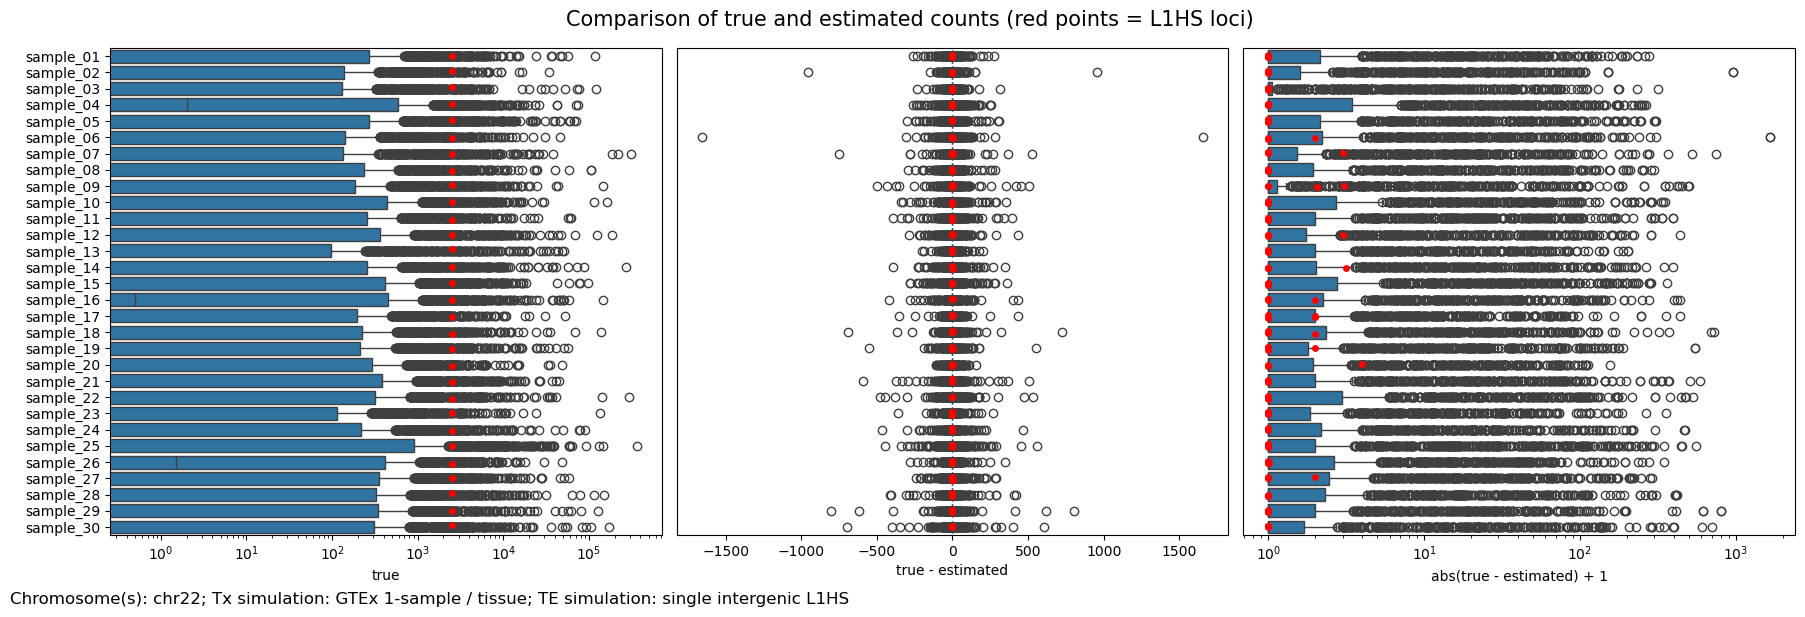

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plots = {
    "count_true": ax1,
    "difference": ax2,
    "abs_difference": ax3,
}
for name, ax in plots.items():
    sns.boxplot(
        data=benchmark[~benchmark.name.str.contains("L1HS")],
        x=name,
        y="sample",
        ax=ax,
    )
    sns.stripplot(
        data=benchmark[benchmark.name.str.contains("L1HS")],
        x=name,
        y="sample",
        ax=ax,
        color="red",
    )

ax1.set(xlabel="true", ylabel=None, xscale="log")
ax2.set(xlabel="true - estimated", ylabel=None, yticklabels=[], yticks=[])
ax3.set(
    xlabel="abs(true - estimated) + 1",
    ylabel=None,
    yticklabels=[],
    yticks=[],
    xscale="log",
)

# set one big title
fig.suptitle(
    "Comparison of true and estimated counts (red points = L1HS loci)", fontsize=15
)

# add txt below plots
fig.text(
    0,
    -0.01,
    "Chromosome(s): chr22; Tx simulation: GTEx 1-sample / tissue; TE simulation: single intergenic L1HS",
    ha="left",
    fontsize=12,
)

fig.tight_layout()

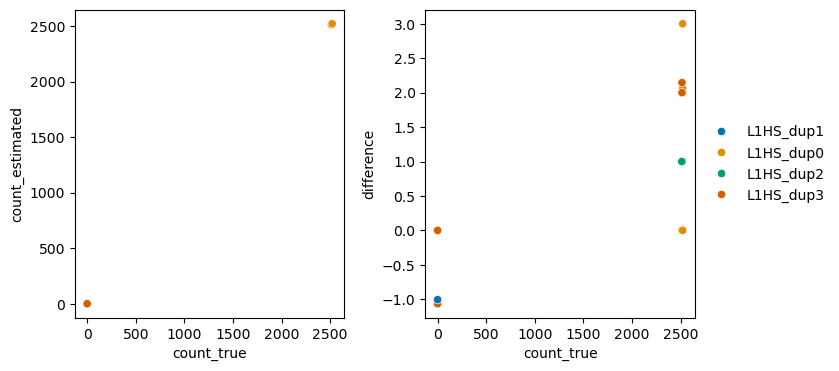

In [7]:
plot_df = benchmark[benchmark.name.str.contains("L1HS")]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# add horizontal space between axes
fig.subplots_adjust(wspace=0.3)

sns.scatterplot(
    data=plot_df,
    x="count_true",
    y="count_estimated",
    hue="name",
    palette="colorblind",
    ax=ax1,
)

sns.scatterplot(
    data=plot_df,
    x="count_true",
    y="difference",
    hue="name",
    palette="colorblind",
    ax=ax2,
)

# remove legends
ax1.legend_.remove()

# move ax2 legend outside
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles=handles,
    labels=labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
)